# Task 36-> Implement with TensorFlow/Keras: Vegetable Image Classification 
Image classification is a fundamental task in computer vision where the goal is to categorize an image into one of several predefined classes. For example, in a typical image classification task, a model might be trained to recognize whether an image contains a potato, a carrot, or a Broccoli.

## Import required libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import warnings
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from itertools import cycle

## Ignore input warnings

In [2]:
warnings.filterwarnings('ignore')

## Define paths


In [3]:
train_path = "/kaggle/input/vegetable-image-dataset/Vegetable Images/train"
validation_path = "/kaggle/input/vegetable-image-dataset/Vegetable Images/validation"
test_path = "/kaggle/input/vegetable-image-dataset/Vegetable Images/test"

## Get image categories


In [4]:
image_categories = os.listdir(train_path)

## Plot sample images


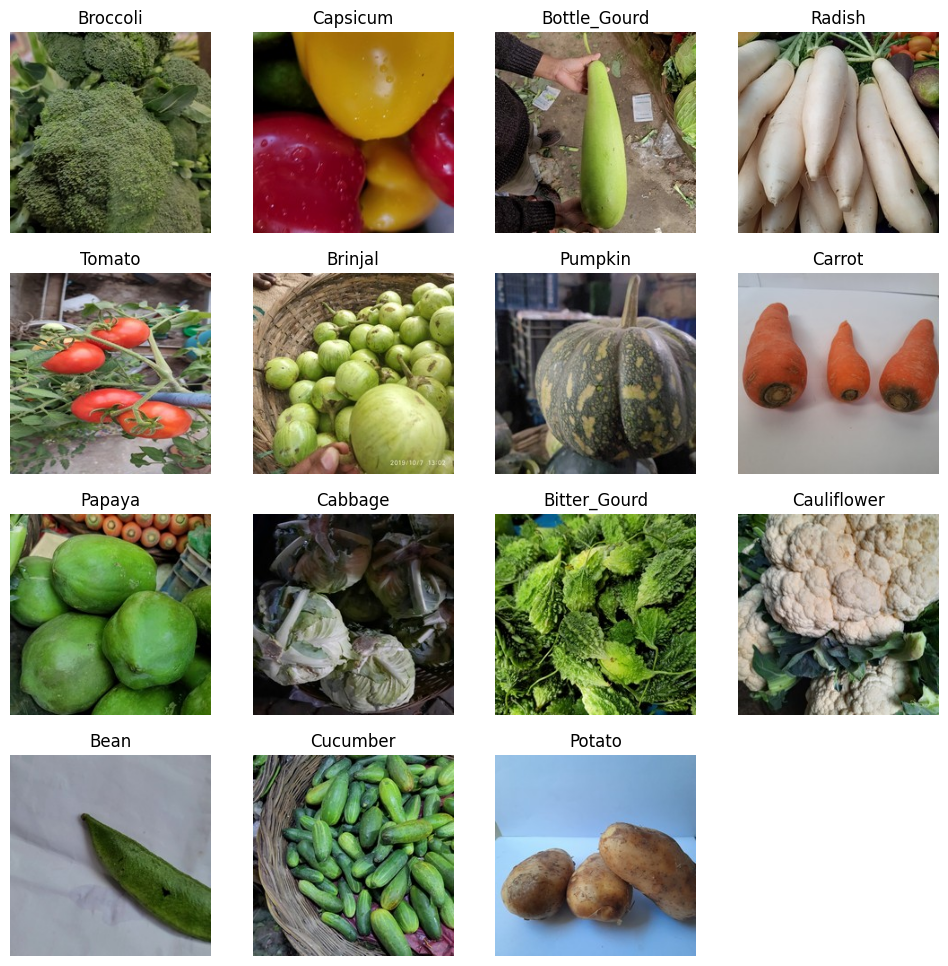

In [5]:
plt.figure(figsize=(12, 12))
for i, cat in enumerate(image_categories):
    image_path = os.path.join(train_path, cat)
    images_in_folder = os.listdir(image_path)
    first_image_path = os.path.join(image_path, images_in_folder[0])
    img = image.load_img(first_image_path)
    img_arr = image.img_to_array(img)/255.0
    
    plt.subplot(4, 4, i+1)
    plt.imshow(img_arr)
    plt.title(cat)
    plt.axis('off')

plt.show()

# Prepare the Dataset
## Creating Image Data Generator for train, validation and test set

## 1. Train Set


In [6]:
train_gen = ImageDataGenerator(rescale = 1.0/255.0)
train_image_generator = train_gen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 15000 images belonging to 15 classes.


## 2. Validation Set


In [7]:
val_gen = ImageDataGenerator(rescale = 1.0/255.0)
val_image_generator = val_gen.flow_from_directory(
    validation_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 3000 images belonging to 15 classes.


## 3. Test Set


In [8]:
test_gen = ImageDataGenerator(rescale = 1.0/255.0)
test_image_generator = test_gen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for maintaining order for confusion matrix
)

Found 3000 images belonging to 15 classes.


## Print class mappings


In [9]:
class_map = dict([(v, k) for k, v in train_image_generator.class_indices.items()])
print("Class mappings:", class_map)

Class mappings: {0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


## Build CNN model


In [10]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dense(15, activation='softmax')
])

## Print model summary


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,654,799 (40.64 MB)

 Trainable params: 10,654,799 (40.64 MB)

 Non-trainable params: 0 (0.00 B)

## Plot model architecture


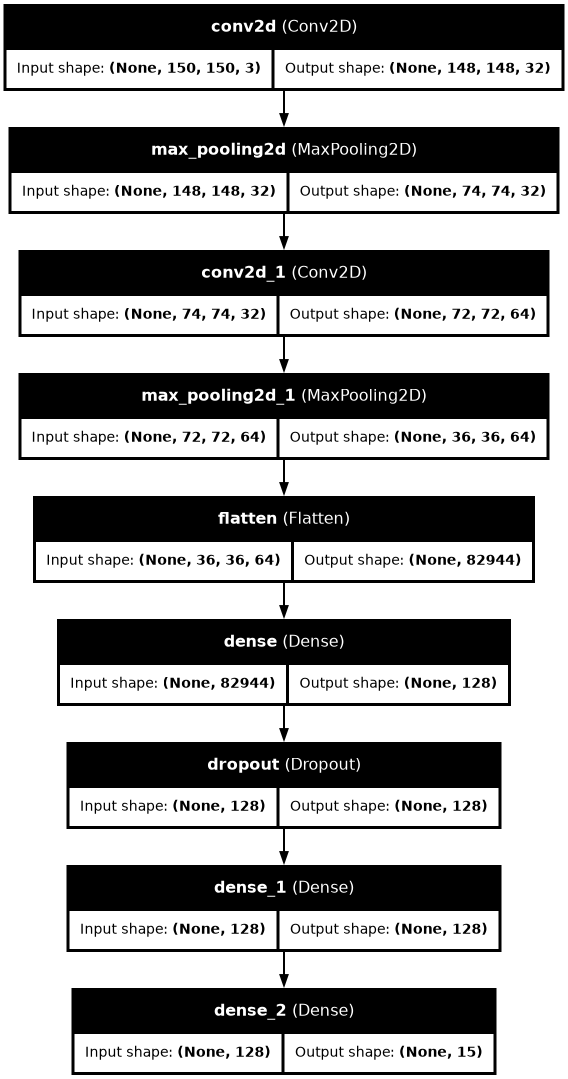

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=72)

## Compile the model
Compilation is the process where the model is configured for training. It involves setting up the loss function, optimizer, and metrics.

### Key Components:

##### 1. Loss Function: 
The loss function measures how far the model's predictions are from the actual labels. In multi-class classification tasks, the categorical cross-entropy loss function is commonly used. This function calculates the difference between the predicted probability distribution and the actual distribution (which is usually a one-hot encoded vector).
##### 2. Optimizer: 
The optimizer updates the weights of the model to minimize the loss function. Popular optimizers include:
###### A. SGD (Stochastic Gradient Descent): 
A simple and effective optimizer.
###### B. Adam: 
An adaptive optimizer that adjusts the learning rate during training, often leading to faster convergence.
###### C. RMSprop: 
Another adaptive learning rate optimizer, commonly used in training deep neural networks.
##### 3. Metrics: 
Metrics are used to evaluate the model’s performance during training and testing. Accuracy is a common metric for classification tasks, representing the percentage of correctly classified images.

In [13]:
early_stopping = keras.callbacks.EarlyStopping(patience=5)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Train and Fit the model

In [16]:
hist = model.fit(
    train_image_generator, 
    epochs=15,  # Reduced for demonstration
    verbose=1, 
    validation_data=val_image_generator, 
    steps_per_epoch = 15000//32, 
    validation_steps = 3000//32, 
    callbacks=[early_stopping]
)

Epoch 1/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 279s 595ms/step - accuracy: 0.6608 - loss: 1.0314 - val_accuracy: 0.8649 - val_loss: 0.4371
Epoch 2/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 280us/step - accuracy: 0.8750 - loss: 0.3472 - val_accuracy: 0.9167 - val_loss: 0.3773
Epoch 3/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 278s 593ms/step - accuracy: 0.8681 - loss: 0.4082 - val_accuracy: 0.9271 - val_loss: 0.2631
Epoch 4/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 249us/step - accuracy: 0.9375 - loss: 0.2249 - val_accuracy: 0.8750 - val_loss: 0.3588
Epoch 5/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 277s 591ms/step - accuracy: 0.9310 - loss: 0.2196 - val_accuracy: 0.9375 - val_loss: 0.2281
Epoch 6/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 253us/step - accuracy: 0.7812 - loss: 0.7234 - val_accuracy: 0.9167 - val_loss: 0.4849
Epoch 7/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 325s 598ms/step - accuracy: 0.9483 - loss: 0.1579 - val_accuracy: 0.9530 - val_loss: 0.1690
Epoch 8/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 259us/step - accuracy: 0.9375 - loss: 0

## Save the trained model


In [17]:
model.save("vegetable_classification_model.h5")

## Plot training history


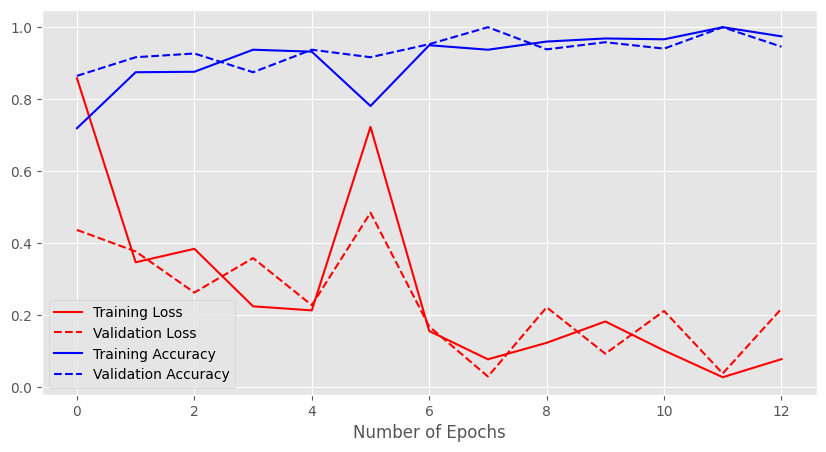

In [18]:
h = hist.history
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

## Evaluate the model on test set


In [19]:
test_loss, test_accuracy = model.evaluate(test_image_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 287ms/step - accuracy: 0.9538 - loss: 0.1852
Test accuracy: 0.9427


## Generate predictions for the test set


In [20]:
predictions = model.predict(test_image_generator)
predicted_classes = np.argmax(predictions, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step


## Get true labels


In [21]:
true_classes = test_image_generator.classes

## Generate classification report


In [22]:
class_labels = list(class_map.values())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

        Bean       0.93      0.94      0.94       200
Bitter_Gourd       0.96      0.97      0.97       200
Bottle_Gourd       0.92      0.99      0.96       200
     Brinjal       0.85      0.96      0.91       200
    Broccoli       0.97      0.90      0.93       200
     Cabbage       0.87      0.96      0.92       200
    Capsicum       1.00      0.97      0.98       200
      Carrot       0.99      1.00      0.99       200
 Cauliflower       0.96      0.83      0.89       200
    Cucumber       0.98      0.85      0.91       200
      Papaya       0.99      0.93      0.96       200
      Potato       0.99      0.99      0.99       200
     Pumpkin       0.94      0.94      0.94       200
      Radish       0.90      0.99      0.94       200
      Tomato       0.93      0.88      0.90       200

    accuracy                           0.94      3000
   macro avg       0.95      0.94      0.94      3000
we

## Generate confusion matrix


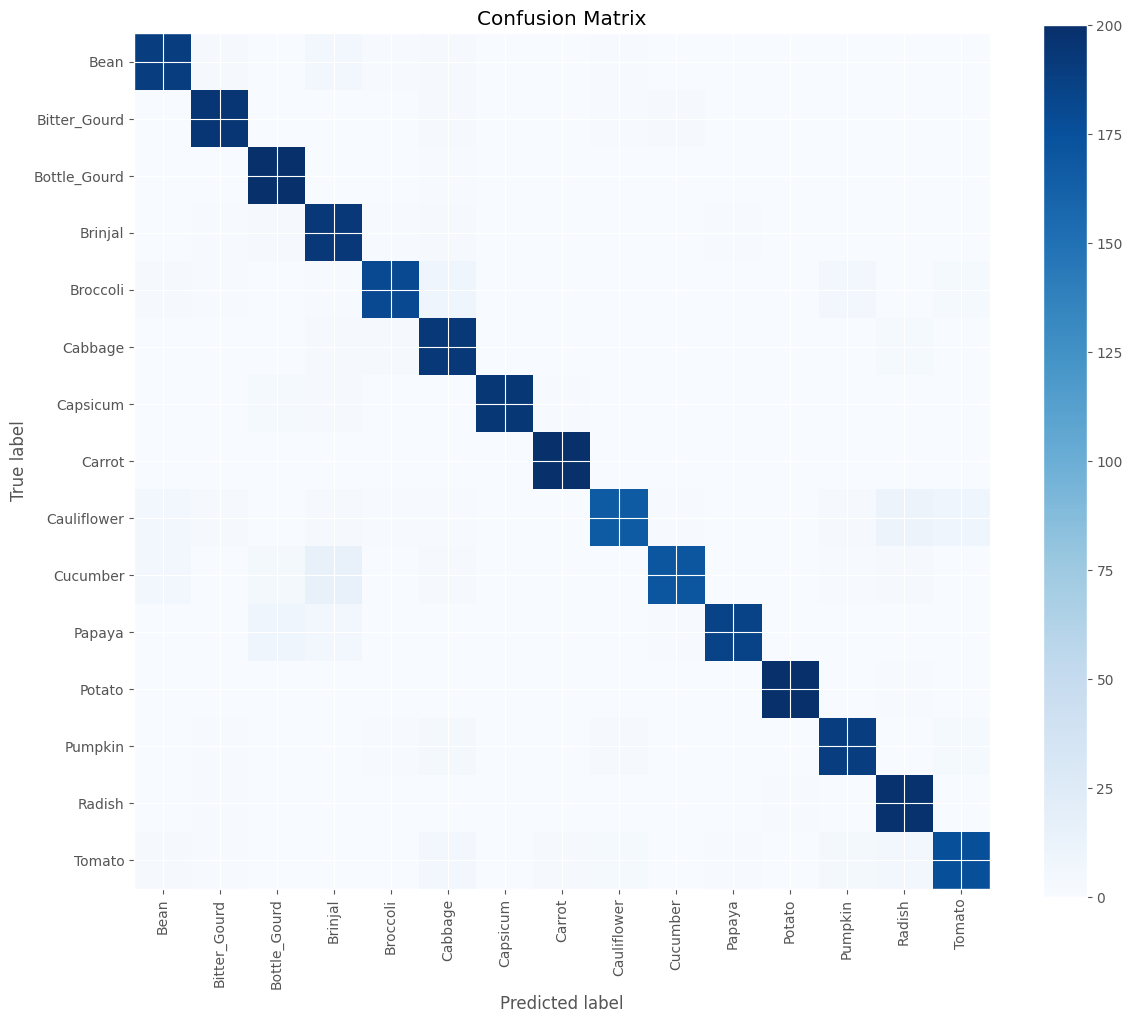

In [23]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=90)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Generate ROC curve


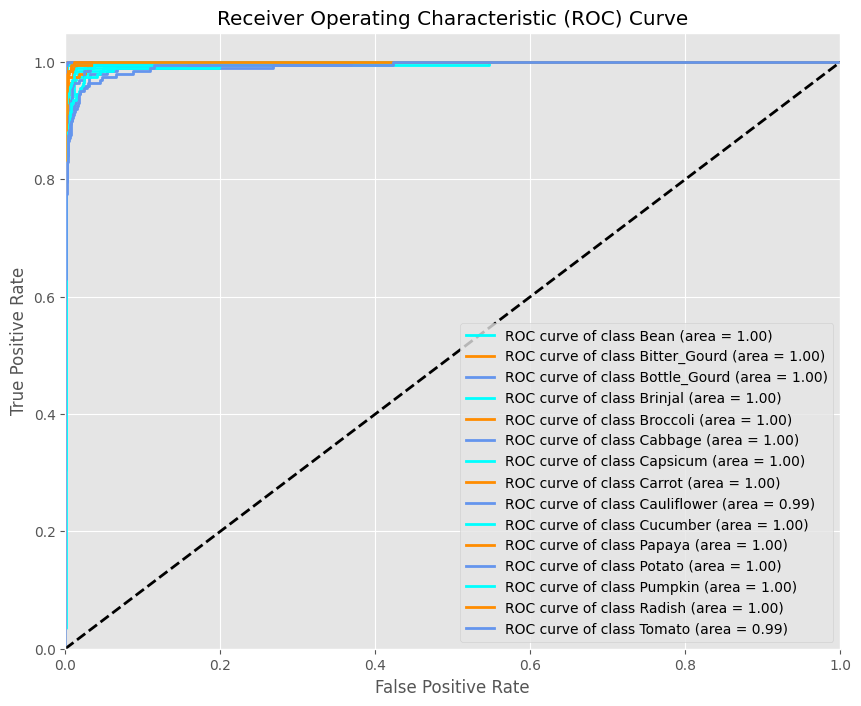

In [24]:
n_classes = len(class_labels)
lb = LabelBinarizer()
lb.fit(true_classes)
y_test = lb.transform(true_classes)
y_score = predictions

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Test on a sample image


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


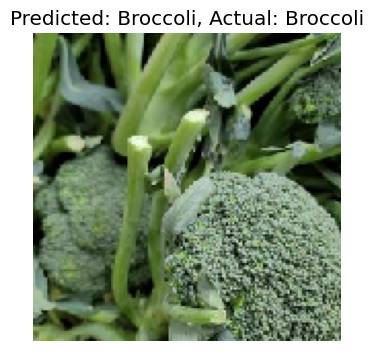

In [25]:
test_image_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Broccoli/1015.jpg'
test_img = image.load_img(test_image_path, target_size=(150, 150))
test_img_arr = image.img_to_array(test_img)/255.0
test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

predicted_label = np.argmax(model.predict(test_img_input))
predicted_vegetable = class_map[predicted_label]
plt.figure(figsize=(4, 4))
plt.imshow(test_img_arr)
plt.title(f"Predicted: {predicted_vegetable}, Actual: Broccoli")
plt.grid()
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


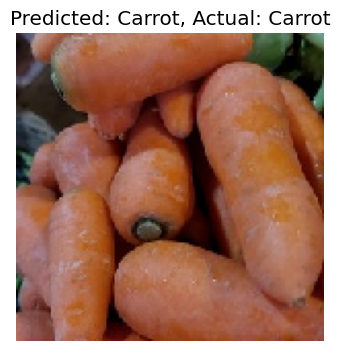

In [26]:
test_image_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Carrot/1013.jpg'
test_img = image.load_img(test_image_path, target_size=(150, 150))
test_img_arr = image.img_to_array(test_img)/255.0
test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

predicted_label = np.argmax(model.predict(test_img_input))
predicted_vegetable = class_map[predicted_label]
plt.figure(figsize=(4, 4))
plt.imshow(test_img_arr)
plt.title(f"Predicted: {predicted_vegetable}, Actual: Carrot")
plt.grid()
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


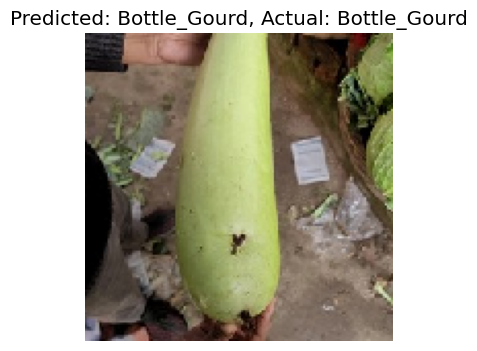

In [28]:
test_image_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Bottle_Gourd/1028.jpg'
test_img = image.load_img(test_image_path, target_size=(150, 150))
test_img_arr = image.img_to_array(test_img)/255.0
test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

predicted_label = np.argmax(model.predict(test_img_input))
predicted_vegetable = class_map[predicted_label]
plt.figure(figsize=(4, 4))
plt.imshow(test_img_arr)
plt.title(f"Predicted: {predicted_vegetable}, Actual: Bottle_Gourd")
plt.grid()
plt.axis('off')
plt.show()